In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, rossby_number, calc_tang_vel, find_directional_radii, compute_tilt_data, bearing

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [21]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


Calculate there vertical centers

In [4]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


In [5]:
# for e, eddy in enumerate(dic_eddies_vert.keys()):
#     dic = dic_eddies_vert[eddy]
#     df = compute_tilt_data(dic, int(eddy[4:]))
#     if e == 0:
#         df_tilt_data = df
#     else:
#         df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
# df_tilt_data.to_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/df_tilt_data.pkl") 

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_tilt_data


,Eddy,Day,TiltDis,TiltDir
0,1,1465,31.669332,89.546110
1,1,1466,33.600109,92.955602
2,1,1467,35.159201,96.662951
3,1,1468,35.643445,101.070039
4,1,1469,34.916207,105.866105
...,...,...,...,...
98431,2927,10643,10.685422,350.104683
98432,2927,10644,10.055826,348.769338
98433,2927,10645,11.563679,343.688930
98434,2927,10646,12.848125,334.097803


In [6]:
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


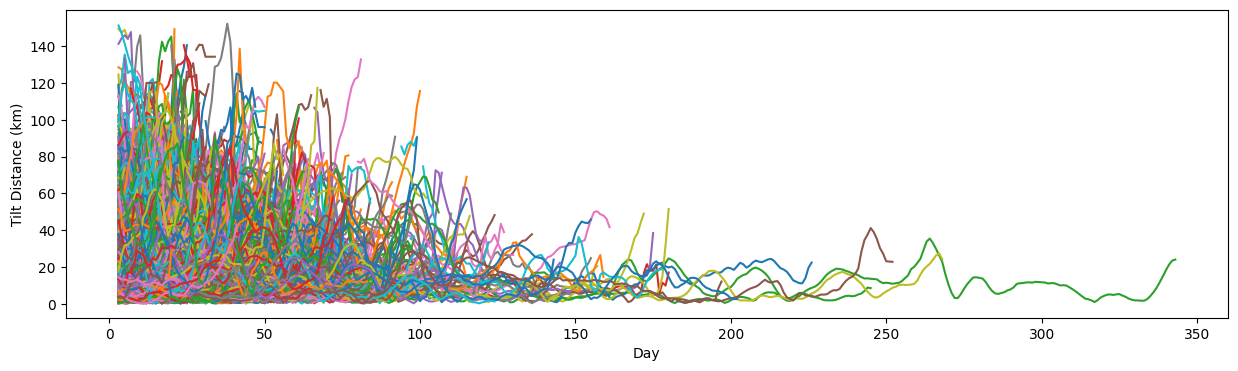

In [7]:
plt.figure(figsize=(15,4))
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    plt.plot(np.arange(len(df)), df['TiltDis'])
    plt.xlabel('Day')
    plt.ylabel('Tilt Distance (km)')
    

In [8]:
def coriolis(lat_deg):
    Omega = 7.2921e-5  # Earth's rotation rate [rad/s]
    return 2 * Omega * np.sin(np.deg2rad(lat_deg))
    
df_eddies['f'] = coriolis(df_eddies.Lat)


ALL
Slope: 1.7206282685109406
Intercept: 81.24470100300083
R²: 0.11925355966503358
p-value: 0.0
Standard error: 0.016376588331449206
AE
Slope: 2.0099756327998035
Intercept: 93.50165465935692
R²: 0.13462321180113498
p-value: 0.0
Standard error: 0.024300251285919117
CE
Slope: 1.6071133985674426
Intercept: 74.79759576248598
R²: 0.12818471743584484
p-value: 0.0
Standard error: 0.021629825422146608


Text(0.5, 0, 'Latititude')

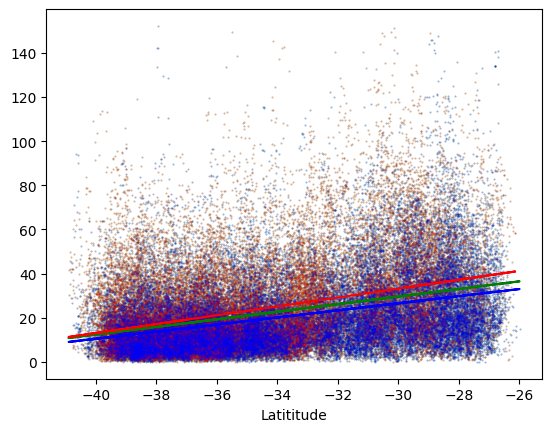

In [9]:
from scipy.stats import linregress

alpha = .2
colors = plt.get_cmap("tab10").colors

# ALL
df = df_eddies.copy().dropna()
y = df.TiltDis
x = df.Lat # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("ALL")
print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.', alpha=alpha, color='g')
plt.plot(x, slope*x + intercept, color='g')

# AE
df = df_eddies.copy().dropna()
df = df[df.Cyc=='AE']
y = df.TiltDis
x = df.Lat # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("AE")
print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.', alpha=alpha, color='r')
plt.plot(x, slope*x + intercept, color='r')

# CE
df = df_eddies.copy().dropna()
df = df[df.Cyc=='CE']
y = df.TiltDis
x = df.Lat # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("CE")
print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.', alpha=alpha, color='b')
plt.plot(x, slope*x + intercept, color='b')

plt.xlabel('Latititude')


Slope: -0.07300120053456573
Intercept: 24.65212087684025
R²: 0.014168996348613929
p-value: 5.422825655217277e-255
Standard error: 0.0021325945744740268


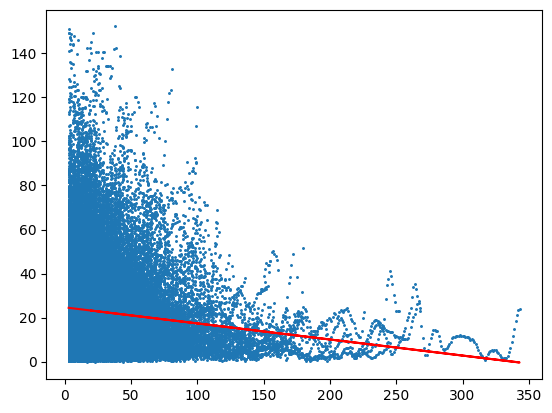

In [10]:
x, y = [], []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if len(df):
        x.extend(np.arange(len(df)))
        y.extend(df.TiltDis)
        # plt.scatter(np.arange(len(df)), df.TiltDis, s=5, marker='.')
df = pd.DataFrame({'x': x, 'y': y}).dropna()
x, y = df.x, df.y

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=5, marker='.')
plt.plot(x, slope*x + intercept, color='red')


Slope: 0.00011142605844200556
Intercept: 21.82760495562167
R²: 0.0002554399383894463
p-value: 5.024198679391388e-06
Standard error: 2.4413694082779012e-05


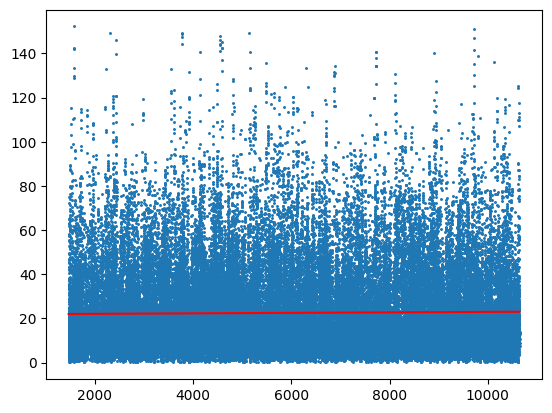

In [11]:
df = df_eddies.copy().dropna()
y = df.TiltDis
x = df.Day 

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=5, marker='.')
plt.plot(x, slope*x + intercept, color='red')


In [12]:
day_idxs = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    if len(df):
        day_idxs.extend(df.Day-df.Day.iloc[0])
df_eddies['Day_idx'] = day_idxs


In [14]:
df_young = df_eddies[df_eddies.Day_idx <= 100]


In [15]:
np.sum(df_young.TiltDis > 40)

np.int64(12159)

In [16]:
np.sum(df_young.TiltDis > 40) / len(df_young)


np.float64(0.1074258956575518)

In [17]:
df_old = df_eddies[df_eddies.Day_idx > 100]
np.sum(df_old.TiltDis > 40)


np.int64(82)

0.0
0.0
0.0


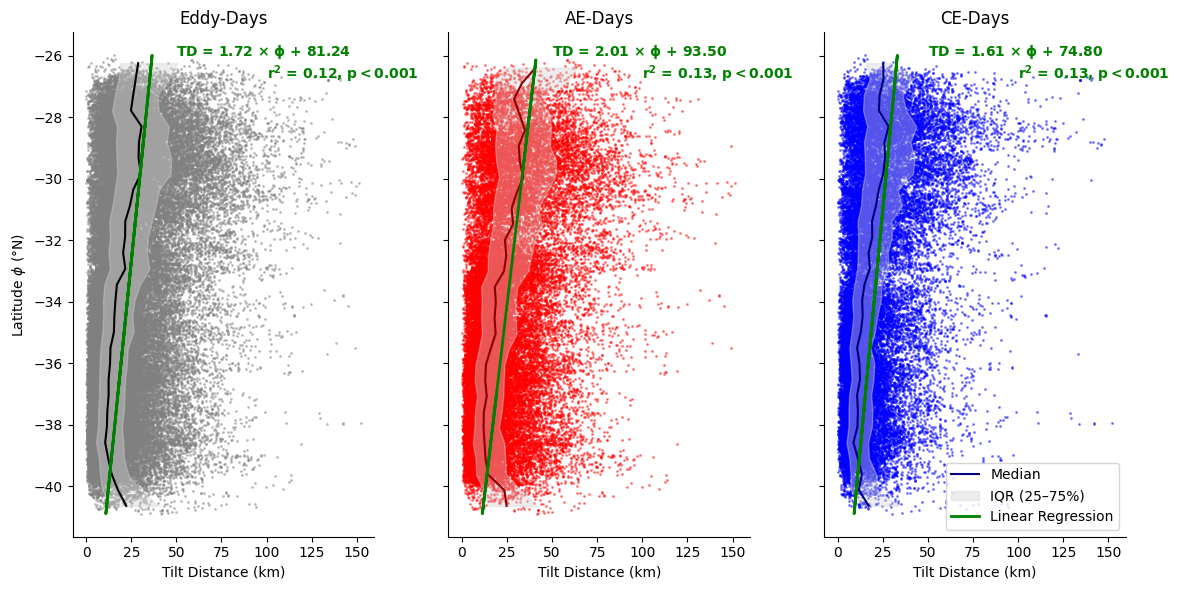

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True, sharex=True)

styles = {
    'Eddy-Days': {'scatter': 'grey',  'line': 'black', 'fill': 'lightgrey'},
    'AE-Days':  {'scatter': 'red',   'line': 'darkred', 'fill': 'lightgrey'},
    'CE-Days':  {'scatter': 'blue',  'line': 'navy', 'fill': 'lightgrey'}
}

for p, cyc in enumerate(['Eddy-Days', 'AE-Days', 'CE-Days']):
    if cyc == 'Eddy-Days':
        df_masked = df_eddies.copy().dropna()
    else:
        df_masked = df_eddies[df_eddies.Cyc==cyc[:2]].copy().dropna()
        
    x = df_masked['TiltDis']
    y = df_masked['Lat']
    
    bins = np.linspace(y.min(), y.max(), 30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    digitized = np.digitize(y, bins)
    
    median = [x[digitized == i].median() for i in range(1, len(bins))]
    q25    = [x[digitized == i].quantile(0.25) for i in range(1, len(bins))]
    q75    = [x[digitized == i].quantile(0.75) for i in range(1, len(bins))]
    
    axs[p].scatter(x, y, marker='.', s=5, alpha=0.4, color=styles[cyc]['scatter'])
    axs[p].plot(median, bin_centers, color=styles[cyc]['line'], label='Median')
    axs[p].fill_betweenx(
        bin_centers,
        q25, q75,
        color=styles[cyc]['fill'],
        alpha=0.4,
        label='IQR (25–75%)'
    )

    y = df_masked['TiltDis']
    x = df_masked['Lat']

    # run regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    axs[p].plot(slope*x + intercept, x, color='g', lw=2, label='Linear Regression')
    axs[p].text(50, -26, fr'TD = {slope:.02f} $\mathbf{{\times}}$ $\mathbf{{\phi}}$ + {intercept:.02f}',
                color='g', fontweight='bold')
    axs[p].text(100, -26.75, fr'$\mathbf{{r^2}}$ = {r_value**2:.02f}, $\mathbf{{p < 0.001}}$',
                color='g', fontweight='bold')
    print(p_value)
    
    axs[p].set_xlabel('Tilt Distance (km)')
    axs[p].set_title(cyc)
    if p ==2:
        axs[p].legend(loc='lower right')
    axs[p].spines['top'].set_visible(False)
    axs[p].spines['right'].set_visible(False)

axs[0].set_ylabel(r'Latitude $\phi$ (°N)')
plt.tight_layout()
plt.show()


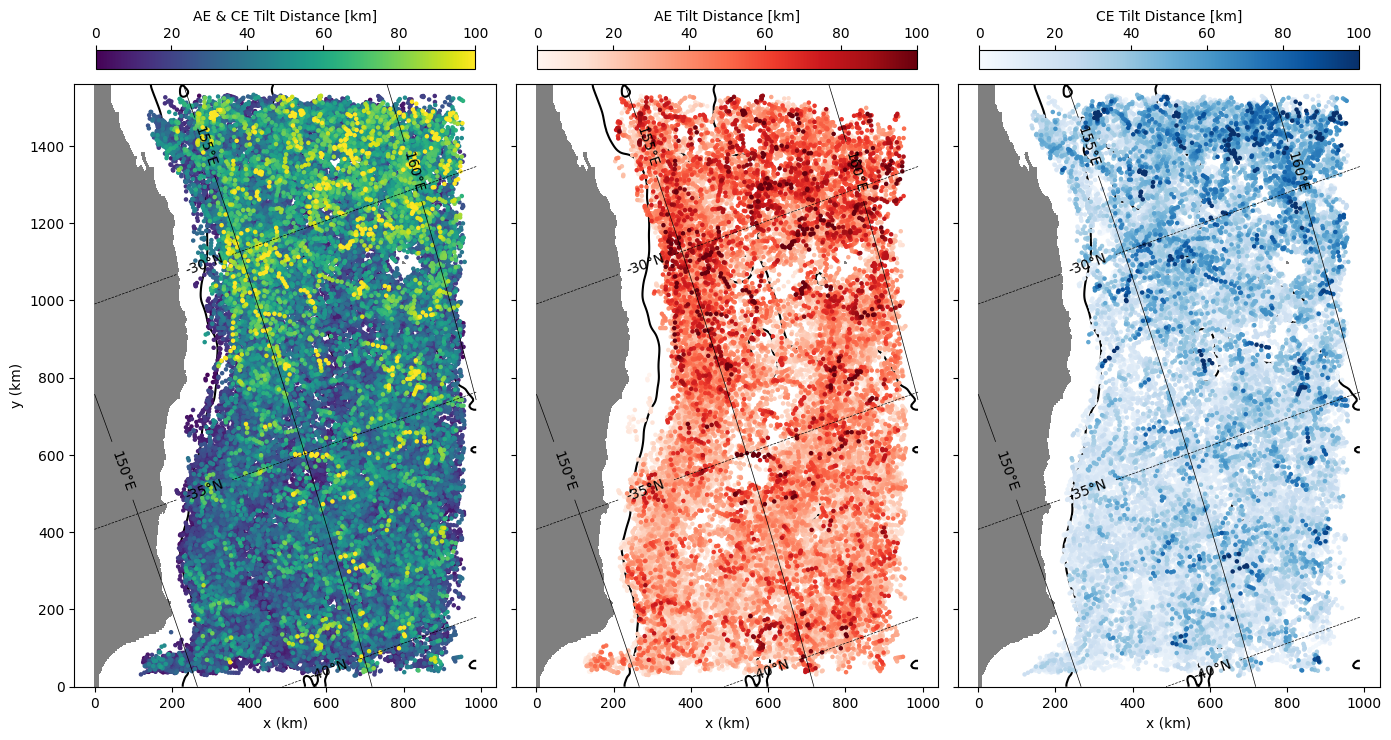

In [14]:
vmin, vmax = 0, 100
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize

norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"AE & CE": "viridis", "AE": "Reds", "CE": "Blues"}

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    sc = ax.scatter(df.xc, df.yc, c=df.TiltDis, s=5, cmap=cmaps[cyc], norm=norm,
                    rasterized=True, zorder=2)
    cb = fig.colorbar(sc, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Tilt Distance [km]')
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{v:.0f}°N", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


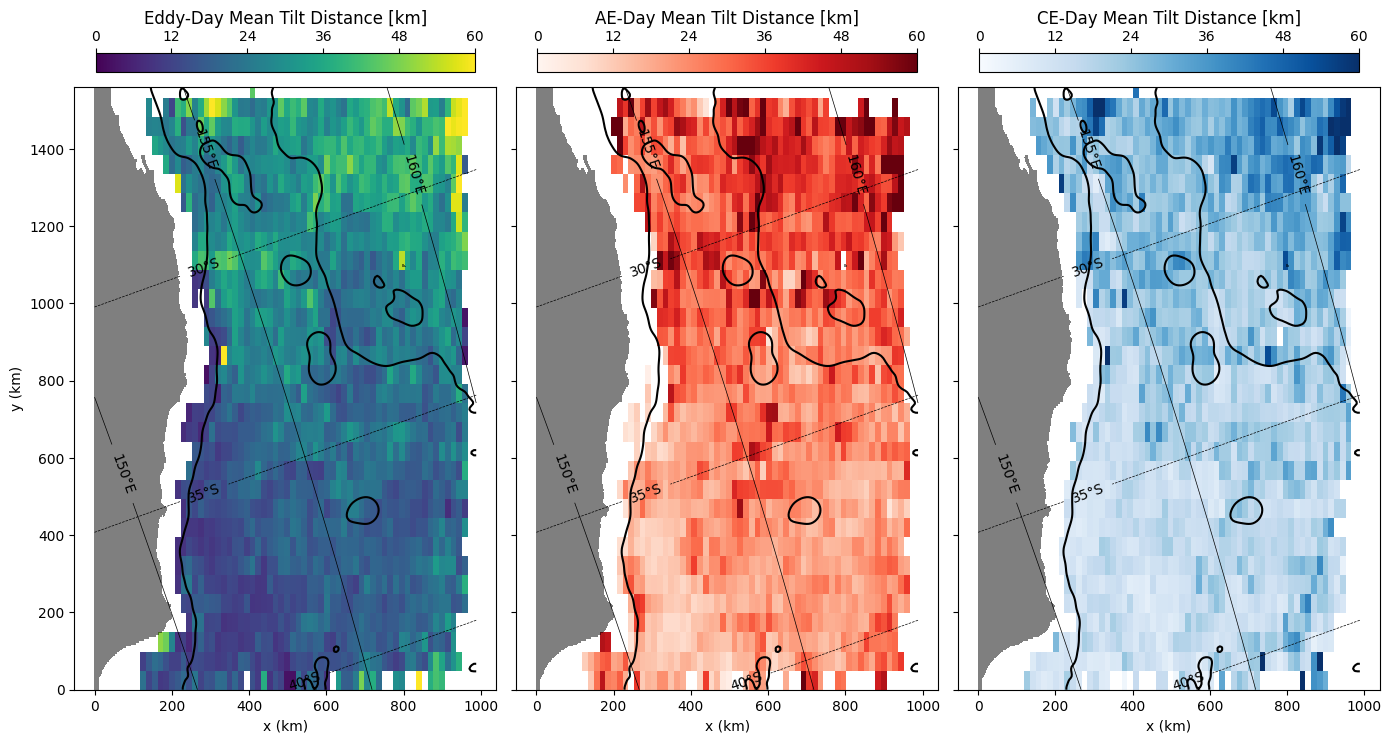

In [19]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)
    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))
    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))
    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)
    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

# compute shared edges once for all panels
xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 60
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"Eddy-Day": "viridis", "AE-Day": "Reds", "CE-Day": "Blues"}

def binned_mean(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix>=0)&(ix<nx)&(iy>=0)&(iy<ny)&np.isfinite(v)
    flat = iy[ok]*nx + ix[ok]
    s = np.bincount(flat, weights=v[ok], minlength=nx*ny)
    c = np.bincount(flat, minlength=nx*ny)
    hmean = np.full(nx*ny, np.nan)
    hmean[c>0] = s[c>0]/c[c>0]
    return hmean.reshape(ny, nx)

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

for p, cyc in enumerate(['Eddy-Day', 'AE-Day', 'CE-Day']):
    ax = axs[p]
    df = df_eddies if cyc == 'Eddy-Day' else df_eddies[df_eddies.Cyc == cyc[:2]]
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_mean(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm, shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Mean Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


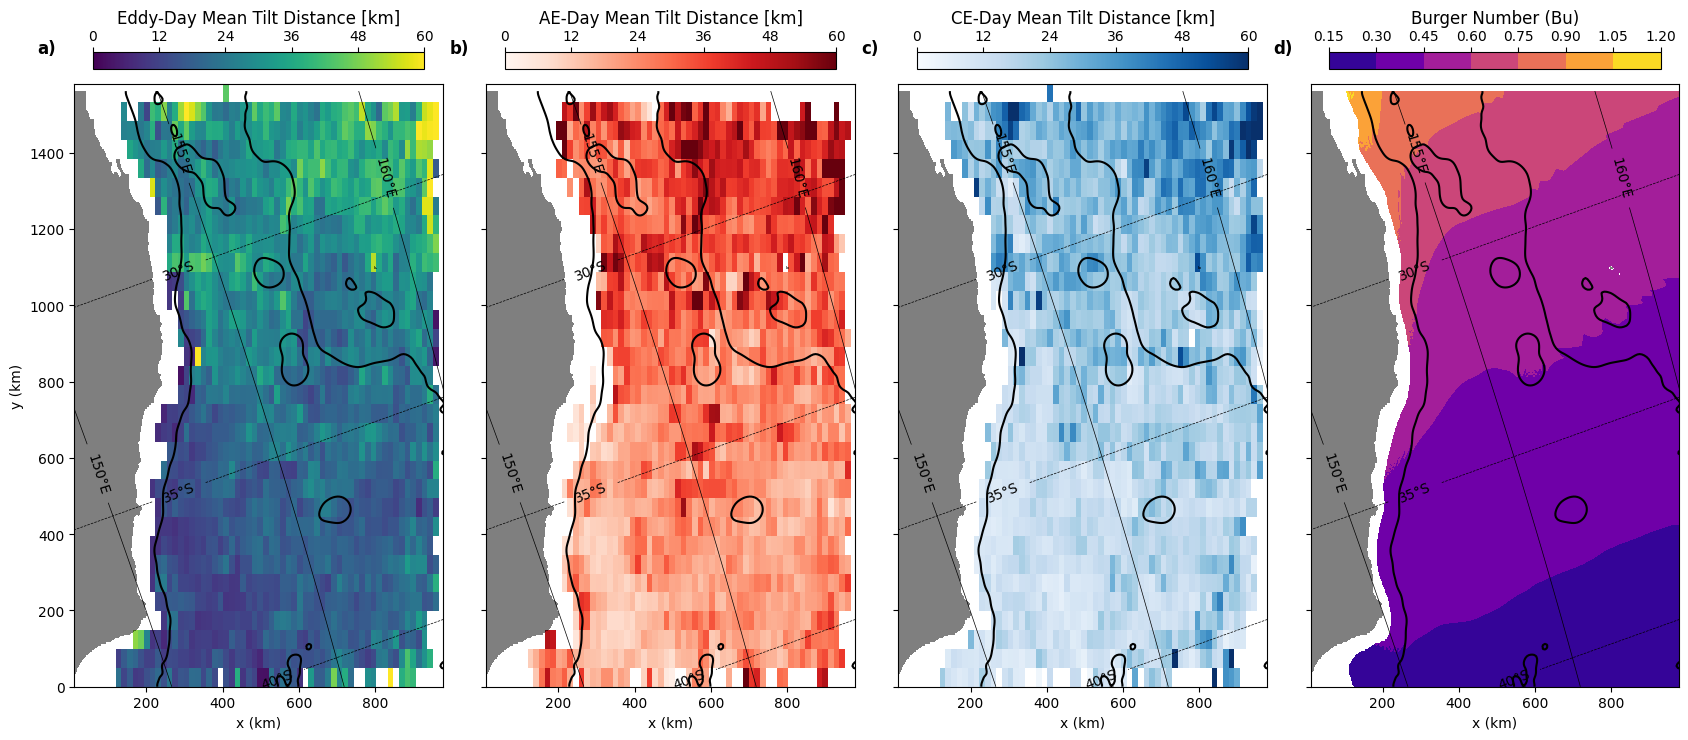

In [24]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)
    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))
    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))
    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)
    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

# compute shared edges once for all panels
xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 60
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"Eddy-Day": "viridis", "AE-Day": "Reds", "CE-Day": "Blues"}

def binned_mean(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix>=0)&(ix<nx)&(iy>=0)&(iy<ny)&np.isfinite(v)
    flat = iy[ok]*nx + ix[ok]
    s = np.bincount(flat, weights=v[ok], minlength=nx*ny)
    c = np.bincount(flat, minlength=nx*ny)
    hmean = np.full(nx*ny, np.nan)
    hmean[c>0] = s[c>0]/c[c>0]
    return hmean.reshape(ny, nx)

fig, axs = plt.subplots(1, 4, figsize=(17, 8), sharey=True)

for p, cyc in enumerate(['Eddy-Day', 'AE-Day', 'CE-Day']):
    ax = axs[p]
    df = df_eddies if cyc == 'Eddy-Day' else df_eddies[df_eddies.Cyc == cyc[:2]]
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_mean(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm, shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Mean Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

ax = axs[3]
H = 300
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
f = np.transpose(dataset.variables['f'], axes=(1, 0))
Bu = ( (Nbar_ave * H) / (f * 50000) )**2
Bu = np.where(mask_rho, Bu, np.nan)
Bu = np.where(h > H, Bu, np.nan)
m = ax.contourf(X_grid, Y_grid, Bu, cmap='plasma')
cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
cb.set_label(f'Burger Number (Bu)', fontsize=12)
ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')
ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]
c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
ax.axis('equal')

tags = ['a)', 'b)', 'c)', 'd)']
for a, ax in enumerate(axs):
    ax.set_xlabel('x (km)')
    ax.text(-0.1, 1.05, tags[a], transform=ax.transAxes, fontsize=12, fontweight='bold')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


### Tilt Distance and Stratifcation

/scratch/pbs.6911347.kman.restech.unsw.edu.au/ipykernel_1139435/3646928111.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label=r'Mean $\widebar{N}$ top 300m')


Text(0, 0.5, 'Latitude (°N)')

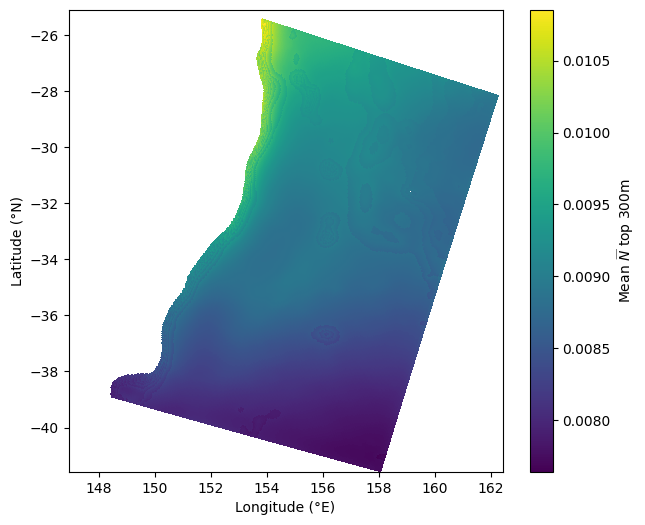

In [44]:
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
plt.figure(figsize=(7,6))
field = np.where(h > 300, Nbar_ave, np.nan)
field = np.where(mask_rho, field, np.nan)
plt.pcolor(lon_rho, lat_rho, field)
plt.colorbar(label=r'Mean $\widebar{N}$ top 300m')
plt.axis('equal')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')


### Increase over time

In [ ]:
df_first = df_eddies[df_eddies.Day <= (df_eddies.Day.min() + 365)]
df_last = df_eddies[df_eddies.Day >= (df_eddies.Day.max() - 365)]


In [ ]:
monthly_mean = df_eddies.groupby(pd.Grouper(key='Date', freq='3YE'))['TiltDis'].mean()

plt.figure(figsize=(10,5))
plt.scatter(df_eddies.Date, df_eddies.TiltDis, s=1, marker='.', alpha=0.5)
plt.plot(monthly_mean.index, monthly_mean.values, color='red', lw=2)
plt.xlabel('Date')
plt.ylabel('Tilt Distance')
plt.ylim(0, 40)
plt.show()


In [ ]:
import matplotlib.cm as cm

ae = df_eddies[df_eddies.Cyc == 'AE'].Eddy.unique()
ce = df_eddies[df_eddies.Cyc == 'CE'].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
        axs[0].set_xlabel('Day', fontsize=12)
        axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        ae_idx += 1
    else:
        axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
        axs[1].set_xlabel('Day', fontsize=12)
        axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        ce_idx += 1
plt.tight_layout()


In [ ]:
AE_TD_mean = df_eddies[df_eddies.Cyc=='AE'].TiltDis.mean()
CE_TD_mean = df_eddies[df_eddies.Cyc=='CE'].TiltDis.mean()
print(f'AE Tilt Distance Mean: {round(AE_TD_mean)}km')
print(f'CE Tilt Distance Mean: {round(CE_TD_mean)}km')


In [ ]:
# Replace these with your actual data arrays
directions = df_eddies.TiltDir
magnitudes = df_eddies.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.show()


In [ ]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()


In [ ]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_AE = df_AE[~df_AE.TiltDis.isna()]
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()
df_CE = df_CE[~df_CE.TiltDis.isna()]


In [ ]:
print('% of AEs tilted northward :')
print(len(df_AE[(df_AE.TiltDir < 90) | (df_AE.TiltDir > 270)]) / len(df_AE))

print('% of AEs tilted northward with easterly component:')
print(len(df_AE[df_AE.TiltDir < 90]) / len(df_AE[(df_AE.TiltDir < 90) | (df_AE.TiltDir > 270)]))

print('% of TD between 0-40km for northward tilts')
df_ae_north = df_AE[(df_AE.TiltDir < 90) | (df_AE.TiltDir > 270)]
print(len(df_ae_north[df_ae_north.TiltDis <= 40]) / len(df_ae_north))


In [ ]:
print('% of CEs tilted southward:')
print(len(df_CE[(df_CE.TiltDir > 90) & (df_CE.TiltDir < 270)]) / len(df_CE))

print('% of CEs tilted southward with easterly component:')
print(len(df_CE[(df_CE.TiltDir > 90) & (df_CE.TiltDir < 180)]) / len(df_CE[(df_CE.TiltDir > 90) & (df_CE.TiltDir < 270)]))

print('% of TD between 0-40km for southward tilts')
df_ce_south = df_CE[(df_CE.TiltDir > 90) & (df_CE.TiltDir < 270)]
print(len(df_ce_south[df_ce_south.TiltDis <= 40]) / len(df_ce_south))


In [ ]:
eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) / 1 * 0.011574))
df_eddies['EddyProp'] = eddy_props
df_eddies


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.EddyProp, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace(df.EddyProp.min(), df.EddyProp.max(), 20)
    groups = df.groupby(pd.cut(df.EddyProp, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Eddy Propagation')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    color = 'r' if cyc == 'AE' else 'b'
    axs[p].scatter(df.w, df.TiltDis, marker='.', color=color, s=1, alpha=.1)

    bins = np.linspace(df.w.min(), df.w.max(), 20)
    groups = df.groupby(pd.cut(df.w, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Vorticity')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()


In [ ]:
df_eddies['h'] = h[df_eddies.ic, df_eddies.jc]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.h/1000, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace((df.h/1000).min(), (df.h/1000).max(), 20)
    groups = df.groupby(pd.cut(df.h/1000, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Bathymetry (km)')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()


In [ ]:
def slope_mag(h, X, Y, mask=None):
    # derivatives wrt index space (i, j)
    x_i, x_j = np.gradient(X)
    y_i, y_j = np.gradient(Y)
    h_i, h_j = np.gradient(h)

    # Jacobian and physical-space gradients
    J = x_i*y_j - x_j*y_i
    dhdx = ( h_i*y_j - h_j*y_i) / J
    dhdy = (-h_i*x_j + h_j*x_i) / J

    S = np.hypot(dhdx, dhdy)          # slope magnitude = tan(theta)
    S[np.isclose(J, 0)] = np.nan       # guard against singular cells
    if mask is not None:               # mask: 1=ocean, 0=land
        S = np.where(mask.astype(bool), S, np.nan)
    return S

s = slope_mag(h/1000, X_grid, Y_grid, mask=mask_rho)

df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].pcolor(lon_rho, lat_rho, s)
axs[0].axis('equal')

for p, cyc in enumerate(['AE', 'CE']):
    p += 1
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.s, df.TiltDis, marker='.', color='r' if p == 1 else 'b', s=1, alpha=.1)

    bins = np.linspace(df.s.min(), df.s.max(), 20)
    groups = df.groupby(pd.cut(df.s, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Magnitude of Bottom Slope')
    axs[p].set_ylabel('Tilt Distance')
    axs[p].set_ylim(-10, 160)
    axs[p].set_xlim(-.005, .150)

plt.tight_layout()



In [ ]:
def eccentricity_from_Q(Q, definition="eccentricity"):
    eigvals = np.linalg.eigvalsh(Q)
    a = 1 / np.sqrt(eigvals.min())
    b = 1 / np.sqrt(eigvals.max())
    
    if definition == "axis_ratio":
        return a / b
    elif definition == "ellipticity":
        return 1 - b / a
    elif definition == "eccentricity":
        return np.sqrt(1 - (b/a)**2)
    else:
        raise ValueError("Unknown definition")

df_eddies['Eccent'] = df_eddies.apply(
    lambda row: eccentricity_from_Q(
        np.array([[np.abs(row.Q11), row.Q12],
                  [row.Q12, np.abs(row.Q22)]])
    ),
    axis=1
)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.Eccent, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace(0, 1, 20)
    groups = df.groupby(pd.cut(df.Eccent, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlim(0, 1)
    axs[p].set_xlabel('Eccentricity')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()




In [ ]:
df_eddies['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies.Day, unit='D')

plt.figure(figsize=(14, 4))
clrs = np.where(df_eddies.Cyc == 'CE', 'b', 'r')
plt.scatter(df_eddies.Date, df_eddies.TiltDis, c=clrs, marker='.', s=15, alpha=0.1)

trend_results = {}
for cyc, colour in [('AE', 'red'), ('CE', 'b')]:
    df_masked = df_eddies[df_eddies.Cyc == cyc]
    grouped = df_masked.groupby(df_masked['Date'].dt.to_period('M'))['TiltDis']
    monthly_mean = grouped.mean()
    monthly_std = grouped.std()
    monthly_mean.index = monthly_mean.index.to_timestamp()
    monthly_std.index = monthly_std.index.to_timestamp()

    plt.plot(monthly_mean.index, monthly_mean, marker='o', color=colour, label=cyc)
    plt.fill_between(monthly_mean.index,
                     monthly_mean - monthly_std,
                     monthly_mean + monthly_std,
                     color=colour, alpha=0.15)

    coeffs = np.polyfit(np.arange(len(monthly_mean)), monthly_mean, 1)
    trend_results[cyc] = coeffs[0]

plt.xlabel('Date')
plt.ylabel('Tilt Distance (Monthly Mean ± STD)')
plt.legend()
plt.tight_layout()

print(f"AE: {'Increasing' if trend_results['AE'] > 0 else 'Decreasing'} {trend_results['AE']*12*1000:.1f} m per year")
print(f"CE: {'Increasing' if trend_results['CE'] > 0 else 'Decreasing'} {trend_results['CE']*12*1000:.1f} m per year")



In [ ]:
df_eddies['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies.Day, unit='D')

fig, axs = plt.subplots(2, 1, figsize=(14, 6))
clrs = np.where(df_eddies.Cyc == 'CE', 'b', 'r')

trend_results = {}
for p, (cyc, colour) in enumerate([('AE', 'red'), ('CE', 'b')]):
    df_masked = df_eddies[df_eddies.Cyc == cyc]
    axs[p].scatter(df_eddies.Date, df_eddies.TiltDis, c=colour, marker='.', s=15, alpha=0.1)
    grouped = df_masked.groupby(df_masked['Date'].dt.to_period('M'))['TiltDis']
    monthly_mean = grouped.mean()
    monthly_std = grouped.std()
    monthly_mean.index = monthly_mean.index.to_timestamp()
    monthly_std.index = monthly_std.index.to_timestamp()

    axs[p].plot(monthly_mean.index, monthly_mean, marker='o', color=colour, label=cyc)
    axs[p].fill_between(monthly_mean.index,
                     monthly_mean - monthly_std,
                     monthly_mean + monthly_std,
                     color='k', alpha=0.25)

    coeffs = np.polyfit(np.arange(len(monthly_mean)), monthly_mean, 1)
    trend_results[cyc] = coeffs[0]
    axs[p].legend()

plt.xlabel('Date')
plt.ylabel('Tilt Distance (Monthly Mean ± STD)')
plt.tight_layout()

print(f"AE: {'Increasing' if trend_results['AE'] > 0 else 'Decreasing'} {trend_results['AE']*12*1000:.1f} m per year")
print(f"CE: {'Increasing' if trend_results['CE'] > 0 else 'Decreasing'} {trend_results['CE']*12*1000:.1f} m per year")



In [ ]:
df_eddies['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies.Day, unit='D')

plt.figure(figsize=(14, 4))
m = df_eddies['Date'].dt.month
clrs = np.where(df_eddies.Cyc == 'CE', 'b', 'r')
plt.scatter(m, df_eddies.TiltDis, c=clrs, marker='.', s=15, alpha=0.1)

for cyc, colour in [('AE', 'red'), ('CE', 'b')]:
    d = df_eddies[df_eddies.Cyc == cyc]
    s = d.groupby(d['Date'].dt.month)['TiltDis'].mean().reindex(range(1, 13))
    x = np.r_[s.index, 13]
    y = np.r_[s.values, s.iloc[0]]
    plt.plot(x, y, marker='o', color=colour, label=cyc)

plt.xlim(.5, 13.5)
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Month')
plt.ylabel('Tilt Distance (Monthly Mean)')
plt.legend()
plt.tight_layout()


In [ ]:
df = df_eddies.copy()
df['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df.Day, unit='D')
season_map = {12:'Summer',1:'Summer',2:'Summer',3:'Autumn',4:'Autumn',5:'Autumn',6:'Winter',7:'Winter',8:'Winter',9:'Spring',10:'Spring',11:'Spring'}
order = ['Summer','Autumn','Winter','Spring']
df['Season'] = pd.Categorical(df['Date'].dt.month.map(season_map), categories=order, ordered=True)

plt.figure(figsize=(10,4))
x_scatter = df['Season'].cat.codes + 1
clrs = np.where(df.Cyc=='CE','b','r')
plt.scatter(x_scatter, df.TiltDis, c=clrs, s=15, alpha=0.1)

for cyc, colour in [('AE','red'), ('CE','b')]:
    s = df[df.Cyc == cyc].groupby('Season', observed=False)['TiltDis'].mean().reindex(order)
    x = np.arange(1, 5)
    plt.plot(x, s.values, marker='o', color=colour, label=cyc)

plt.xticks(np.arange(1,5), order)
plt.xlabel('Season')
plt.ylabel('Tilt Distance (Seasonal Mean)')
plt.legend()
plt.tight_layout()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Example data (replace with actual df data)
eddy_prop = np.array(df_eddies.Eccent)
df_TiltDis = df_eddies.TiltDis

mask = ~np.isnan(eddy_prop) & ~np.isnan(df_TiltDis)
X = eddy_prop[mask].reshape(-1, 1)
y = df_TiltDis[mask]

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

plt.scatter(X, y, marker='.', s=15)
plt.plot(X, y_pred, color='red', linewidth=2) 
# plt.xlabel('Eddy Propagation (m/s)')
plt.ylabel('Tilt Distance')
plt.title(f'Best Fit Line (R² = {r2:.3f})')
plt.show()


### Tilt Direction

In [ ]:
df_eddies

In [ ]:
plt.scatter(df_eddies.TiltDis, df_eddies.TiltDir, marker='.', s=1)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def pingpong_cmap(color_a, color_b, name='pingpong', N=256, mid=0.5):
    return LinearSegmentedColormap.from_list(
        name, [(0.0, color_a), (mid, color_b), (1.0, color_a)], N=N
    )

# examples
cmap_bw = pingpong_cmap('black', 'yellow') 


In [ ]:
vmin, vmax = None, None
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize

norm = Normalize(vmin=vmin, vmax=vmax)
# cmaps = {"AE & CE": "viridis", "AE": "Reds", "CE": "Blues"}
cmaps = {"AE & CE": cmap_bw, "AE": cmap_bw, "CE": cmap_bw}

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]
    df = df.sort_values('TiltDir', kind='mergesort', ignore_index=True)#, ascending=False)

    sc = ax.scatter(df.xc, df.yc, c=df.TiltDir, s=1, cmap=cmaps[cyc], norm=norm,
                    rasterized=True, zorder=2)
    cb = fig.colorbar(sc, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Tilt Distance [km]')
    # cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{v:.0f}°N", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


In [ ]:
plt.contourf(X_grid, Y_grid, h, cmap='Grays')
plt.contour(X_grid, Y_grid, h, levels=[4000], colors='r')
plt.axis('equal')

plt.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['k'], alpha=.5)

In [ ]:
plt.hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDis.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDis.dropna(), bins=100)
plt.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')

plt.ylim(-2200, 2200)
plt.axhline(0, color='k', linewidth=1)
plt.xlabel('Tilt Distance (km)')
plt.ylabel('Number of Eddy-Days')

yticks = plt.gca().get_yticks()
plt.yticks(yticks, [abs(int(t)) for t in yticks])


In [ ]:
plt.hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDir.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDir.dropna(), bins=100)
plt.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')

plt.ylim(-1000, 1000)
plt.axhline(0, color='k', linewidth=1)
plt.xlabel('Tilt Direction (° True North)')
plt.ylabel('Number of Eddy-Days')

yticks = plt.gca().get_yticks()
plt.yticks(yticks, [abs(int(t)) for t in yticks])


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Tilt Distance ---
axs[0].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDis.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDis.dropna(), bins=100)
axs[0].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[0].set_ylim(-2200, 2200)
axs[0].axhline(0, color='k', linewidth=1)
axs[0].set_xlabel('Tilt Distance (km)')
axs[0].set_ylabel('Number of Eddy-Days')
yticks = axs[0].get_yticks()
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([abs(int(t)) for t in yticks])

# --- Tilt Direction ---
axs[1].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDir.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDir.dropna(), bins=100)
axs[1].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[1].set_ylim(-1000, 1000)
axs[1].axhline(0, color='k', linewidth=1)
axs[1].set_xlabel('Tilt Direction (° True North)')
axs[1].set_ylabel('Number of Eddy-Days')
yticks = axs[1].get_yticks()
axs[1].set_yticks(yticks)
axs[1].set_yticklabels([abs(int(t)) for t in yticks])

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


In [ ]:
###### col_labels = ['A','B','C']
row_labels = ['1','2','3','4']  # counted from bottom

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)

def bin_counts(df):
    H, _, _ = np.histogram2d(df.yc, df.xc, bins=[y_edges, x_edges])
    return H.astype(int).T  # (ncols, nrows)

df_valid = df_eddies[~np.isnan(df_eddies.TiltDis)].copy() # how many valid

for cyc, df in {
    'AE & CE': df_valid,
    'AE': df_valid[df_valid.Cyc=='AE'],
    'CE': df_valid[df_valid.Cyc=='CE']
}.items():
    H = bin_counts(df)
    print(f"\n{cyc}")
    for i, col in enumerate(col_labels):
        for j, row in enumerate(row_labels):
            print(f"{col}{row}: {H[i, j]}")


#### Where is tilt not being measured?

In [ ]:
# df_nt = df_eddies.copy()
# df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_eddies[~np.isnan(df_eddies.TiltDis)].copy()
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].scatter(df_nt.xc, df_nt.yc, s=1, marker='.')
axs[0].axis('equal')
df_ae = df_nt[df_nt.Cyc=='AE']
axs[1].scatter(df_ae.xc, df_ae.yc, s=1, marker='.', color='r')
axs[1].axis('equal')
df_ce = df_nt[df_nt.Cyc=='CE']
axs[2].scatter(df_ce.xc, df_ce.yc, s=1, marker='.', color='b')
axs[2].axis('equal')
plt.tight_layout


In [ ]:
df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_nt[(np.abs(df_nt.Day_idx-(df_nt.Age-1)) > 2) & (df_nt.Day_idx > 2)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

cmaps = ['Greens', 'Reds', 'Blues']
labels = ['Eddy-Day Count', 'AE-Day Count', 'CE-Day Count']
# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_nt, df_nt[df_nt.Cyc == 'AE'], df_nt[df_nt.Cyc == 'CE']]):
    eddy_x = subset.xc
    eddy_y = subset.yc
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap=cmaps[d])
    fig.colorbar(pcm, ax=axs[d], label=labels[d])
    
    axs[d].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

    axs[d].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

def cell_counts_valid_invalid(df):
    out, vmax = {}, 0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            v = np.count_nonzero(~sub.TiltDis.isna())
            sub_excluding_beg_end = sub[(np.abs(sub.Day_idx-(sub.Age-1)) > 2) & (sub.Day_idx > 2)]
            iv = np.count_nonzero(sub_excluding_beg_end.TiltDis.isna())
            c = np.array([v, iv], dtype=int)
            out[(i,j)] = c
            vmax = max(vmax, v)  # <— track max valid only
    return out, (1 if vmax == 0 else vmax)

def make_autopct(vals):
    total = np.sum(vals)
    def _inner(pct):
        v = int(round(pct*total/100.0))
        return f"{v}" if v > 0 else ""
    return _inner

def add_pie_valid_invalid(ax, x0, y0, counts, tmax, frac=0.25, tick_flag=False, title='', color=plt.cm.Greens(0.6)):
    if counts is None or counts.sum() == 0: return
    s_base = frac * min(cell_w, cell_h)
    scale = 0.35 + 0.65 * (counts[0] / tmax)  # <— use valid only
    s = s_base * scale
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)
    iax.pie(counts, startangle=90, counterclock=False,
            colors=[color, plt.cm.Greys(0.55)],
            wedgeprops={'edgecolor':'k','linewidth':0.3},
            autopct=make_autopct(counts), pctdistance=0.65,
            textprops={'fontsize':12, 'fontweight': 'bold'})
    iax.set_aspect('equal'); iax.set_xticks([]); iax.set_yticks([])
    for spine in iax.spines.values(): spine.set_visible(False)
    if tick_flag:
        ax.legend(handles=[
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color,
                       markeredgecolor='k', markersize=10, label='Valid Tilt'),
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=plt.cm.Greys(0.55),
                       markeredgecolor='k', markersize=10, label='Invalid Tilt')],
            loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1.35, .9),
            title=title, title_fontsize=12)

fracs = [1.2, 1.2, 1.2]
fig, axs = plt.subplots(1, 3, figsize=(20, 9), sharey=True)
colors = [plt.cm.Greens(0.6), plt.cm.Reds(0.6), plt.cm.Blues(0.6)]
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, tmax = cell_counts_valid_invalid(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            tick_flag = (i == 2 and j == 3)
            add_pie_valid_invalid(ax, xc, yc, counts_map[(i,j)], tmax, frac=fracs[p],
                                  tick_flag=tick_flag, color=colors[p], title=f'{titles[p]}:')
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs: ax.set_xlabel('x (km)', fontsize=11)
axs[0].set_ylabel('y (km)', fontsize=11)
plt.tight_layout(); plt.show()


In [ ]:
len(df_eddies)

In [ ]:
df_valid = df_eddies[(np.abs(df_eddies.Day_idx-(df_eddies.Age-1)) > 2) & (df_eddies.Day_idx > 2)].copy()
len(df_valid[~df_valid.TiltDis.isna()])/ len(df_valid)

In [ ]:
len(df_valid[~df_valid.TiltDis.isna()])

In [ ]:
len(df_valid)


#### Background Flow

In [ ]:
break

In [ ]:
with open('/srv/scratch/z5297792/Climatology/dic_mean_flow.pkl', 'rb') as f:
    dic_mean_flow = pickle.load(f)
u_mean, v_mean = dic_mean_flow['u_mean'], dic_mean_flow['v_mean']


In [ ]:
k = 0
plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, v_mean[:, :, k], cmap='coolwarm')
plt.colorbar(label='v mean [m/s]')
plt.contour(lon_rho, lat_rho, v_mean[:, :, k], levels=[0])
plt.axis('equal')
plt.xlabel('Lon')
plt.xlabel('Lat')

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for p, k in enumerate([0, 7, 13, 18, 20, 22, 23, 24]):
    ax = axs[p // 4, p % 4]
    cf = ax.contourf(X_grid, Y_grid, v_mean[:, :, k])
    fig.colorbar(cf, ax=ax)
    ax.contour(X_grid, Y_grid, v_mean[:, :, k], levels=[0])
    ax.axis('equal')
    ax.set_title(str(-round(z_r[k]))+'m Depth')
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for p, jc in enumerate([51, 152, 253]):
    cf = axs[p].contourf(x_grid, -z_r/1000, v_mean[:, jc, :].T)
    fig.colorbar(cf, ax=axs[p])
    axs[p].contour(x_grid, -z_r/1000, v_mean[:, jc, :].T, levels=[0])
    axs[p].invert_yaxis()
    axs[p].set_title(f'y={round(y_grid[jc])}')
plt.tight_layout()


In [ ]:
df_eddies['SurfVFlow'] = v_mean[df_eddies.ic, df_eddies.jc, 0]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.SurfVFlow, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace(df.SurfVFlow.min(), df.SurfVFlow.max(), 20)
    groups = df.groupby(pd.cut(df.SurfVFlow, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('V Flow (ms-1)')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()


In [ ]:
df_eddies

In [ ]:
for e, eddy in enumerate(dic_eddies_vert.keys()):
    if e <=10:
        dic = dic_eddies_vert[eddy]
        for day in dic.keys():
            df = dic_eddies_vert[eddy][day]
            if len(df):
        
                # Find closest grid points
                from scipy.spatial import cKDTree
                tree = cKDTree(np.column_stack((X_grid.ravel(), Y_grid.ravel())))
                xcs = df['x'].to_numpy()
                ycs = df['y'].to_numpy()
                valid = np.isfinite(xcs) & np.isfinite(ycs)
                
                idx = np.full(xcs.shape, -1, dtype=int)
                if valid.any():
                    _, ind = tree.query(np.column_stack((xcs[valid], ycs[valid])))
                    ii, jj = np.unravel_index(ind, X_grid.shape)
                    idx[valid] = ind  # keep for optional debugging
                
                    ics = np.full(xcs.shape, np.nan)
                    jcs = np.full(ycs.shape, np.nan)
                    ics[valid] = ii
                    jcs[valid] = jj
                else:
                    ics = np.full(xcs.shape, np.nan)
                    jcs = np.full(ycs.shape, np.nan)
                df['ic'] = ics
                df['jc'] = jcs
                df['aveU'] = u_mean[df.ic.astype(int), df.jc.astype(int), df.z.astype(int)]
                df['aveV'] = v_mean[df.ic.astype(int), df.jc.astype(int), df.z.astype(int)]
                df['dxdz'] = 1000*df.x.diff() / (-df.Depth.diff())
                df['dydz'] = 1000*df.y.diff() / (-df.Depth.diff())
                

In [ ]:
all_dydz = []
all_aveV = []

for e, eddy in enumerate(dic_eddies_vert.keys()):
    if e <= 10:
        dic = dic_eddies_vert[eddy]
        for day, df in dic.items():
            if len(df):
                all_dydz.extend(df.TD.values)
                all_aveV.extend(df.aveV.values)

all_dydz = np.array(all_dydz)
all_aveV = np.array(all_aveV)
mask = (~np.isnan(all_dydz)) & (~np.isnan(all_aveV))
all_dydz = all_dydz[mask]
all_aveV = all_aveV[mask]

# Pearson correlation
corr = np.corrcoef(all_dydz, all_aveV)[0,1]
print("Pearson correlation:", corr)

plt.scatter(all_dydz, all_aveV, marker='.', s=1)
plt.xlabel("dydz")
plt.ylabel("ave. V")
plt.show()

